In [1]:
import pandas as pd

# Data Loading

In [2]:
from api.data_handler import DataHandler

# Creation of a DataHandler Object
data_handler = DataHandler(['id', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'target_x', 'target_y', 'target_z'])

# Load the Training/Test sets into pandas DataFrames
df_train : pd.DataFrame = data_handler.load_data(f'data/cup/ML-CUP23-TR.csv', delimiter=',')
df_test  : pd.DataFrame = data_handler.load_data(f'data/cup/ML-CUP23-TS.csv', delimiter=',')

# Print the head of the loaded data
print(df_train.head())
print(df_test.head())

   id      col1      col2      col3      col4      col5      col6      col7  \
0   1 -0.917280 -0.712727 -0.989904  0.992819  0.993649  0.995543  0.711074   
1   2 -0.858784  0.998755 -0.998396  0.999909  0.316503 -0.951897 -0.163139   
2   3 -0.990441  0.958726 -0.998675  0.997216  0.987166  0.356483 -0.279689   
3   4  0.937117  0.984474 -0.612420  0.999812  0.728623 -0.539962 -0.165939   
4   5 -0.906628 -0.884567 -0.932487  0.941037  0.978134  0.998179  0.749606   

       col8      col9     col10   target_x   target_y   target_z  
0  0.407645 -0.688548  0.616890   7.897453 -35.936382  21.077147  
1  0.980982  0.661759 -0.800155  -9.330632  19.901571   6.069154  
2  0.599163 -0.684630  0.922901  14.849400   3.374090  19.667479  
3  0.999352 -0.921444 -0.974766 -46.591854  13.734777  17.953600  
4 -0.590599 -0.508268  0.691798   8.217500 -45.885254  14.894251  
   id      col1      col2      col3      col4      col5      col6      col7  \
0   1 -0.983589  0.989514 -0.998539  0.99944

# Data Split

In [3]:
# Saving the ID columns
df_id_train: pd.DataFrame = df_train['id']
df_id_test: pd.DataFrame = df_test['id']

# Drop the ID columns
df_train = df_train.drop(columns=['id'],axis=1).copy(deep=True)
df_test = df_test.drop(columns=['id'],axis=1).copy(deep=True)

# Split of columns and rows (0.8/0.2) into: TR set and Internal TS set
x_train, y_train, x_internal_test, y_internal_test = data_handler.split_data(
    data=df_train,
    cols_name_split=['target_x','target_y','target_z'],
    rows_split_perc=0.8
)

# Split on columns
x_test, y_test = data_handler.split_data(data=df_test, cols_name_split=['target_x','target_y','target_z'])

# Print of the shapes
print(f"[IDs TR SET]: " + str(df_id_train.shape))
print(f"[IDs TS SET]: " + str(df_id_test.shape))
print(f"[TR SET - x]: " + str(x_train.shape))
print(f"[TR SET - y]: " + str(y_train.shape))
print(f"[Internal TS SET - x]: " + str(x_internal_test.shape))
print(f"[Internal TS SET - y]: " + str(y_internal_test.shape))
print(f"[TS SET - x]: " + str(x_test.shape))
print(f"[TS SET - y]: " + str(y_test.shape))

[IDs TR SET]: (1000,)
[IDs TS SET]: (900,)
[TR SET - x]: (800, 10)
[TR SET - y]: (800, 3)
[Internal TS SET - x]: (200, 10)
[Internal TS SET - y]: (200, 3)
[TS SET - x]: (900, 10)
[TS SET - y]: (900, 3)


/Users/gianlucapanzani/anaconda3/envs/ML/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# 1-Hot Encoding

In [4]:
# Applies the 1-Hot Encoding to the "x" data
#x_train = data_handler.one_hot_encoding(x_train)
#x_test  = data_handler.one_hot_encoding(x_test)
# Print of the data modified
#print(f"[TR SET]: " + str(x_train.shape))
#print(f"[TS SET]: " + str(x_test.shape))

# Grid Search parameters

In [5]:
# Parameters' space for Grid Search
param_space = {
    'input_size': [17],
    'hidden_size': [2, 3],
    'output_size': [3],
    'hidden_layers': [0],
    'input_activation': ['Sigmoid'],
    'tolerance': [0.02],
    'learning_rate': [0.8, 0.4],
    'batch_size': [2, 3],
    'momentum': [0.4, 0.3],
    'weight_init': ["glorot_normal", "he_normal"], #["glorot_uniform", "glorot_normal", "he_uniform", "he_normal"],
    'epochs': [400, 350],
    'hidden_activation': ['Tanh', 'Sigmoid'],
    'optimizer': ['SGD'],
    'metrics': ['accuracy']
}

# Model Selection

## Best Hyperparameters Research

In [6]:
from sklearn.model_selection import StratifiedKFold
from api.pytorch.binary_nn import BinaryNN

# Creation of a BinaryNN objct for each dataset
nn: BinaryNN = None

# Different values per dataset
trials = 20
k = 5

# Search of the best Hyperparameters
X = x_train.values.astype(dtype=float)
y = y_train.values.astype(dtype=float)

# K-fold Cross-validation
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Sets all the combinations of the entire set of parameters
#data_handler.set_params_combinations(params=param_space[dataset_i])

# Gets the list with the combinations of all the parameters
#params_combinations = data_handler.get_params_combinations()

# For each iteration we choose the hyperparameters (randomly) and we use them with K-fold CV
#for trial, params in enumerate(params_combinations):
for trial in range(trials):

    # Choose random hyperparameters
    params = data_handler.random_dictionary(params=param_space)

    # Creation of the Neural Network object
    nn_i = BinaryNN(params=params, current_trial=trial+1, trials=trials)
                    
    # For each K-fold returns the indexes of the data splitted in: <X_train,y_train> and <X_val,y_val>
    for train_index, val_index in kfold.split(X, y):
        x_kfold_train, x_kfold_val = X[train_index], X[val_index]
        y_kfold_train, y_kfold_val = y[train_index], y[val_index]

        nn_i.fit(
            x_train=x_kfold_train,
            y_train=y_kfold_train,
            x_val=x_kfold_val,
            y_val=y_kfold_val
        )

    # Case of first assignment
    if nn is None:
        nn = nn_i
    
    # Print the results of this trial
    print("\n------------------ Current Hyperparameters ------------------")
    nn_i.print_training_info()
    print("------------------ CUP Best Hyperparameters -----------------")
    nn.print_training_info()
    print("\n\n")

    # Update best hyperparameters if: no overfitting AND (higher mean VL accuracy OR (equal mean AND
    if nn_i.mean_tr_accuracy-0.1 <= nn_i.mean_vl_accuracy \
        and (
            nn.mean_vl_accuracy < nn_i.mean_vl_accuracy \
            or (
                nn.mean_vl_accuracy == nn_i.mean_vl_accuracy \
                and nn.mean_tr_accuracy < nn_i.mean_tr_accuracy
            )
        ):
        nn = nn_i
    
    # Case of higher mean VL accuracy AND NO Overfitting
    if nn_i.mean_vl_accuracy > nn.mean_vl_accuracy \
        and (
            abs(nn_i.mean_tr_accuracy - nn_i.mean_vl_accuracy) < abs(nn.mean_tr_accuracy - nn.mean_vl_accuracy) \
            or abs(nn_i.mean_tr_accuracy - nn_i.mean_vl_accuracy) < 0.02
        ):
        nn = nn_i
    
    # Exit case
    if nn_i.mean_tr_accuracy == 1 and nn_i.mean_vl_accuracy == 1 \
        and nn_i.mean_vl_loss < 0.1 and nn_i.mean_tr_loss < 0.1 \
        and abs(nn_i.mean_vl_loss - nn_i.mean_tr_loss) < 0.01:
        nn = nn_i
        break

# Print output
print(f"### Best Hyperparameters for CUP ###")
nn.print_training_info()
print("\n\n")


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous-multioutput' instead.

## Retraining Phase


### Retraining of Monk 1 ###
 Monk:                     1
 Trial:                    1/1
 Hyperparameters:          {'input_size': 17, 'hidden_size': 3, 'hidden_layers': 0, 'input_activation': 'Sigmoid', 'tolerance': 0.02, 'learning_rate': 0.8, 'batch_size': 2, 'momentum': 0.3, 'weight_init': 'glorot_normal', 'epochs': 350, 'hidden_activation': 'Tanh', 'optimizer': 'SGD', 'metrics': 'accuracy'}
 Mean Training Loss:       0.013199920669250473
 Mean Validation Loss:     0.018250669199125755
 Mean Training Accuracy:   0.9839079405831651
 Mean Validation Accuracy: 0.9778565101860053

### Retraining of Monk 2 ###
 Monk:                     2
 Trial:                    1/1
 Hyperparameters:          {'input_size': 17, 'hidden_size': 4, 'hidden_layers': 1, 'input_activation': '', 'tolerance': 0.01, 'learning_rate': 0.1, 'batch_size': 3, 'momentum': 0.3, 'weight_init': 'glorot_normal', 'epochs': 350, 'hidden_activation': 'Tanh', 'optimizer': 'SGD', 'metrics': 'accuracy'}
 Mean Training Loss: 

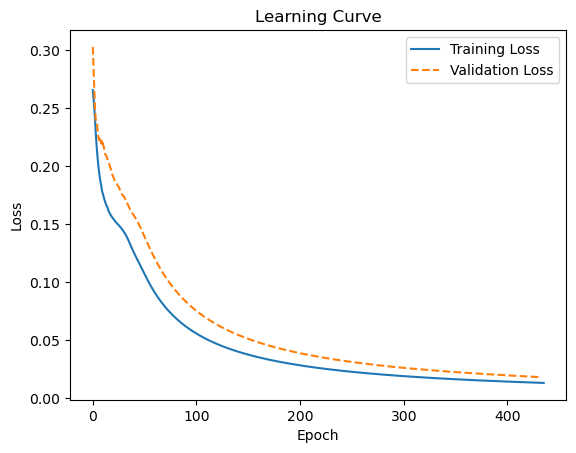

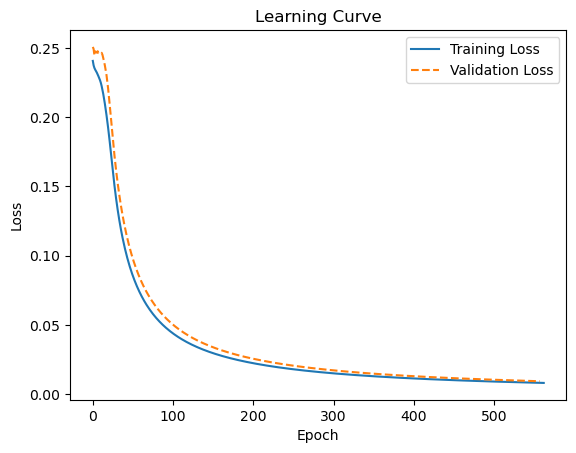

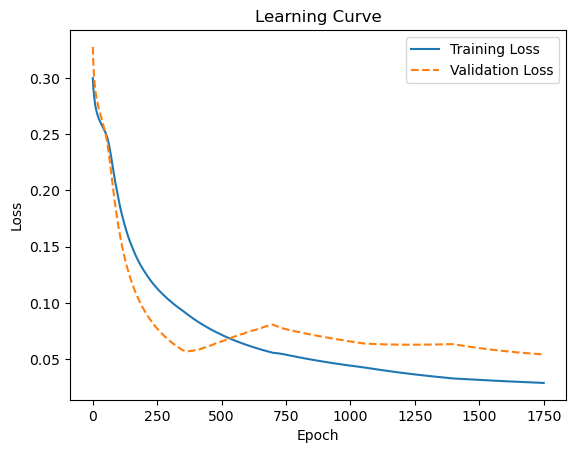

In [ ]:
# Training the model
nn.fit(
    x_train=x_train.values,
    y_train=y_train.values
)

# Print values
print(f"\n### Retraining for CUP ###")
nn.print_training_info()
nn.print_plot()

## Evaluation on different Weights Initializations

In [ ]:
import numpy as np

# Iterations on each Dataset
'''for dataset_i in range(datasets_number):

    # Initializations
    mean_accuracies_list = []

    # Iterations for compute the mean of the accuracy of each Best Model
    iterations = 5
    for i in range(iterations):
        x_train, x_val = data_handler.split_data(df_train[dataset_i], 'target', axis=0).values.astype(dtype=float)
        y_train, y_val = data_handler.split_data(df_test[dataset_i], 'target', axis=0).values.astype(dtype=float)


        # Creates the model with the Best Hyperparameters
        nn_i = BinaryNN(params=nn[dataset_i].params, monk_i=dataset_i+1, current_trial=i+1, trials=iterations,
                        n_hidden_layers=n_hidden_layers_list[dataset_i])
        
        # Training the model
        nn_i.fit(
            x_train=x_train,
            y_train=y_train,
            x_val=x_val,
            y_val=y_val
        )

        # Append the evaluation values
        mean_accuracies_list.append(nn_i.mean_vl_accuracy)

    mean_accuracy = np.mean(mean_accuracies_list)
    print(mean_accuracy)'''

"for dataset_i in range(datasets_number):\n\n    # Initializations\n    mean_accuracies_list = []\n\n    # Iterations for compute the mean of the accuracy of each Best Model\n    iterations = 5\n    for i in range(iterations):\n        x_train, x_val = data_handler.split_data(df_train[dataset_i], 'target', axis=0).values.astype(dtype=float)\n        y_train, y_val = data_handler.split_data(df_test[dataset_i], 'target', axis=0).values.astype(dtype=float)\n\n\n        # Creates the model with the Best Hyperparameters\n        nn_i = BinaryNN(params=nn[dataset_i].params, monk_i=dataset_i+1, current_trial=i+1, trials=iterations,\n                        n_hidden_layers=n_hidden_layers_list[dataset_i])\n        \n        # Training the model\n        nn_i.fit(\n            x_train=x_train,\n            y_train=y_train,\n            x_val=x_val,\n            y_val=y_val\n        )\n\n        # Append the evaluation values\n        mean_accuracies_list.append(nn_i.mean_vl_accuracy)\n\n    mea

# Testing Phase

(432, 17)
(432,)
 Monk:                     1
 Trial:                    1
 Hyperparameters:          {'input_size': 17, 'hidden_size': 3, 'hidden_layers': 0, 'input_activation': 'Sigmoid', 'tolerance': 0.02, 'learning_rate': 0.8, 'batch_size': 2, 'momentum': 0.3, 'weight_init': 'glorot_normal', 'epochs': 350, 'hidden_activation': 'Tanh', 'optimizer': 'SGD', 'metrics': 'accuracy'}
 Mean Training Loss:       0.013199920669250473
 Mean Validation Loss:     0.018250669199125755
 Test Loss:                0.0002953690306359916
 Mean Training Accuracy:   0.9839079405831651
 Mean Validation Accuracy: 0.9778565101860053
 Test Accuracy:            1.0
 f1 score:                 1.0
 f2 score:                 1.0
 Prediction score:         1.0
 Recall score:             1.0

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                216                  0
Real_Class_1                  0                216


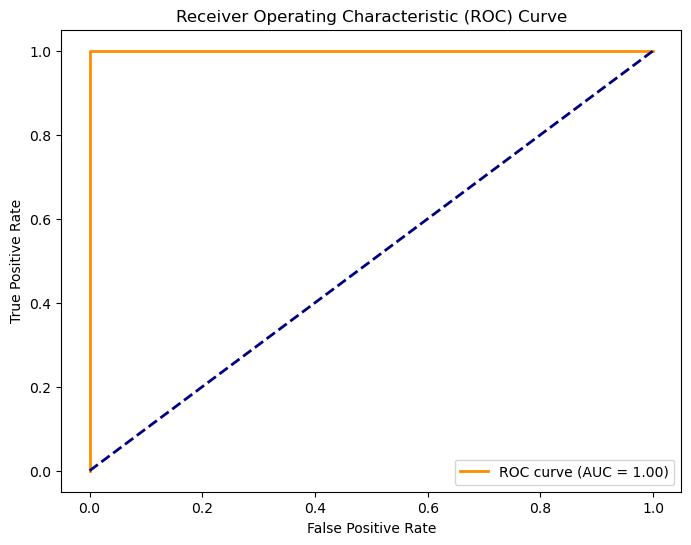

(432, 17)
(432,)
 Monk:                     2
 Trial:                    1
 Hyperparameters:          {'input_size': 17, 'hidden_size': 4, 'hidden_layers': 1, 'input_activation': '', 'tolerance': 0.01, 'learning_rate': 0.1, 'batch_size': 3, 'momentum': 0.3, 'weight_init': 'glorot_normal', 'epochs': 350, 'hidden_activation': 'Tanh', 'optimizer': 'SGD', 'metrics': 'accuracy'}
 Mean Training Loss:       0.008128573062395738
 Mean Validation Loss:     0.009320553978270021
 Test Loss:                0.00015276467572928397
 Mean Training Accuracy:   0.987892889537406
 Mean Validation Accuracy: 0.9841104841104841
 Test Accuracy:            1.0
 f1 score:                 1.0
 f2 score:                 1.0
 Prediction score:         1.0
 Recall score:             1.0

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                290                  0
Real_Class_1                  0                142


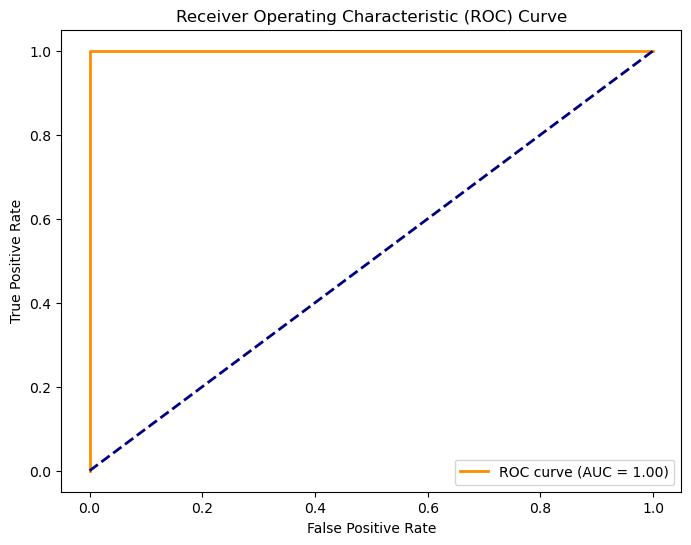

(432, 17)
(432,)
 Monk:                     3
 Trial:                    3
 Hyperparameters:          {'input_size': 17, 'hidden_size': 3, 'hidden_layers': 1, 'input_activation': 'Tanh', 'tolerance': 0.025, 'learning_rate': 0.01, 'batch_size': 3, 'momentum': 0.4, 'weight_init': 'he_normal', 'epochs': 350, 'weight_decay': 0.001, 'hidden_activation': 'ReLU', 'optimizer': 'SGD', 'metrics': 'accuracy'}
 Mean Training Loss:       0.02894646286893446
 Mean Validation Loss:     0.05426674521310061
 Test Loss:                0.24844013389010833
 Mean Training Accuracy:   0.9660587288678123
 Mean Validation Accuracy: 0.93405895691608
 Test Accuracy:            0.7175925925925927
 f1 score:                 0.6347305389221557
 f2 score:                 0.5206286836935167
 Prediction score:         1.0
 Recall score:             0.4649122807017544

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                204                  0
Real_Class_1                122                10

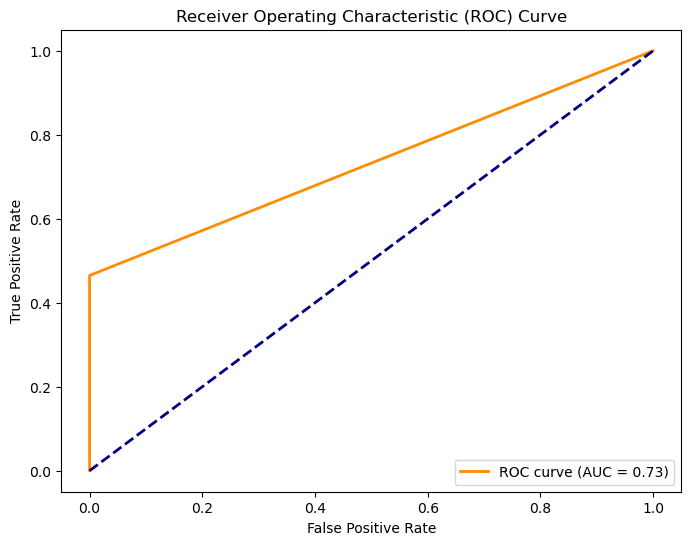

In [ ]:

# Evaluation of the Model
print(x_test.shape)
print(y_test.shape)

X = x_test.values
y = y_test.values

# Evaluate the Model on TS set
nn.test(
    x_test=X,
    y_test=y
)

# Computes the score of the Model
nn.score()

# Prints the results obtained
print(nn)
nn.print_confusion_matrix(y_test=y)
nn.print_roc_curve(y_test=y)

